In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Files
path = "C:/Users/alex/Hands-On-Machine Learning/Project - Mammography/Data/"
train0 = path + "training10_0.tfrecords"
train1 = path + "training10_1.tfrecords"
train2 = path + "training10_2.tfrecords"
train3 = path + "training10_3.tfrecords"
train4 = path + "training10_4.tfrecords"
training_file_list = [train0,train1,train4,train3,train4]

In [3]:
def decode_tfrecord(filenames):
    
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
            'label': tf.FixedLenFeature([], tf.int64),
            'label_normal': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string)
        })

    # now return the converted data
    label = features['label']
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])

    return label, image

def load_image_data(filenames,image_count):
    
    label, image = decode_tfrecord(filenames)
    images_batch, labels_batch = tf.train.batch([image, label], batch_size=image_count,allow_smaller_final_batch=True)
    global_step = tf.Variable(0, trainable=False)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        labels_out, images_out = sess.run([labels_batch, images_batch])

        coord.request_stop()

        # Wait for threads to stop
        coord.join(threads)
        return labels_out, images_out

In [5]:
#Load in Training Data (image counts specifies the amount of entries desired 55,890 is the maximum) 
train_lab, train_img = load_image_data(training_file_list,image_count=60000)

In [6]:
#Load in Test Image Data
cv10_img = np.load(path + "cv10_data.npy")
cv10_lab = np.load(path + "cv10_labels.npy")
test10_img = np.load(path + "test10_data.npy")
test10_lab = np.load(path + "test10_labels.npy")

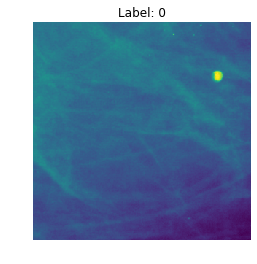

In [7]:
#Compare some test data
plt.imshow(test10_img[1].reshape([299,299]))
plt.axis('off')
plt.title("Label: " + str(test10_lab[1]))
#plt.savefig('C:/Users/alexd/Downloads/ddsm-mammography/Images/Image_' + str(j) + str(i) + ".png", bbox_inches='tight')
plt.show()

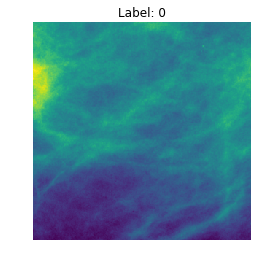

In [8]:
#Okay cv10 is different from train10
plt.imshow(cv10_img[1].reshape([299,299]))
plt.axis('off')
plt.title("Label: " + str(cv10_lab[1]))
#plt.savefig('C:/Users/alexd/Downloads/ddsm-mammography/Images/Image_' + str(j) + str(i) + ".png", bbox_inches='tight')
plt.show()

In [9]:
def img_processor(image,rot,flip):
    #Vertical Flip
    if flip == 1:
        im = np.flipud(image)
    #Horizontal Flip
    elif flip == 2:
        im = np.fliplr(image)
    else:
        im = image
    
    #0 degree
    if rot == 0:
        im = im
    #90 degree
    elif rot == 1:
        im=np.rot90(im)
    #180 degree
    elif rot == 2:
        im = np.rot90(np.rot90(im))
    #270 degree
    else: 
        im = np.rot90(np.rot90(np.rot90(im)))

    return im 

def img_generator(image):
    #Random 
    flips = np.random.randint(0,3,2)
    flips = np.repeat(flips,3)
    rots =  np.random.randint(0,4,6)
    
    images = []
    
    #Generate Images
    for i in range(6):
        x = img_processor(image,flips[i],rots[i])
        images.append(x)
    
    return images

In [10]:
def dat_processor(images,labels):
    pos_img = images[labels != 0]
    neg_img = images[labels == 0]
    org_pos_len = pos_img.shape[0]
    
    pos_aug_list = []
    
    for i in range(org_pos_len):
        pos_aug_list = pos_aug_list + img_generator(pos_img[i])
    
    pos_aug = np.array(pos_aug_list)
    
    pos_len = pos_aug.shape[0]
    neg_len = neg_img.shape[0]
    
    pos_lab = np.repeat(1,pos_len)
    neg_lab = np.repeat(0,neg_len)
    
    return pos_aug, pos_lab, neg_img, neg_lab    

In [11]:
def batch_data_processor(files):
    
    for i in range(len(files)):
    
        train_lab, train_img = load_image_data([files[i]],image_count=60000)
        pos_images,pos_labels,neg_images,neg_labels = dat_processor(train_img,train_lab)
        
        images = np.concatenate((pos_images,neg_images),axis=0)
        labels = np.concatenate((pos_labels,neg_labels),axis=0)
        
        np.save(path + "train_img_aug_" + str(i) + ".npy",images)
        np.save(path + "train_lab_aug_" + str(i) + ".npy",labels)

In [12]:
batch_data_processor(training_file_list)

In [4]:
def raw_dat_processor(images,labels):
    pos_img = images[labels != 0]
    neg_img = images[labels == 0]
    
    pos_len = pos_img.shape[0]
    neg_len = neg_img.shape[0]
    
    pos_lab = np.repeat(1,pos_len)
    neg_lab = np.repeat(0,neg_len)
    
    return pos_img, pos_lab, neg_img, neg_lab    

In [5]:
def raw_batch_processor(files):
    for i in range(len(files)):

        train_lab, train_img = load_image_data([files[i]],image_count=60000)
        pos_images,pos_labels,neg_images,neg_labels = raw_dat_processor(train_img,train_lab)

        images = np.concatenate((pos_images,neg_images),axis=0)
        labels = np.concatenate((pos_labels,neg_labels),axis=0)

        np.save(path + "train_img_raw_" + str(i) + ".npy",images)
        np.save(path + "train_lab_raw_" + str(i) + ".npy",labels)

In [7]:
raw_batch_processor(training_file_list)